
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Implementation of ReverseLayerF class**

In [ ]:
from torch.autograd import Function

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

**Customized implementation of AlexNet**

In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x, alpha):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        #feature = self.features(x)
        #features = self.features.view(-1, features.size(0))

        # During training -> outputs = net(images, alpha)
        if (alpha is not None):
          reverse_feature = ReverseLayerF.apply(x, alpha)
          x = self.domain_classifier(reverse_feature)
          return x
        else: 
          x = self.classifier(x)
          return x
        

def alexnet(pretrained=False, progress=True, **kwargs):
    model = AlexNet(**kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
        model.domain_classifier[1].weight.data = model.classifier[1].weight.data
        model.domain_classifier[1].bias.data = model.classifier[1].bias.data

        model.domain_classifier[4].weight.data = model.classifier[4].weight.data
        model.domain_classifier[4].bias.data = model.classifier[4].bias.data

    model.classifier[6] = nn.Linear(4096, 7)
  
    return model

**Import libraries**

In [ ]:
import os
import logging
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torch.utils.model_zoo import load_url as load_state_dict_from_url

from PIL import Image
from tqdm import tqdm

**Evaluation function**

In [ ]:
def evaluation(loader, net):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  
  for images, labels in tqdm(loader):

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images, None)
    valLoss = criterion(outputs, labels)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(loader.dataset))

  return accuracy, valLoss.item()

**Training function**

In [ ]:
def training(alpha, train_dataloader, net, NUM_EPOCHS, scheduler, optimizer):
  net = net.to(DEVICE) 
  cudnn.benchmark
  current_step = 0
  
  for epoch in range(NUM_EPOCHS):
    # print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    
    for images, labels in train_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() 
      optimizer.zero_grad()

      if alpha is not None:
        outputs = net(images, alpha)
      else: 
        outputs = net(images, None)

      loss = criterion(outputs, labels)

      #if current_step % LOG_FREQUENCY == 0:
        #print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()
      optimizer.step() 
      current_step += 1

    scheduler.step()
  return copy.deepcopy(net)

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                   
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./homework_3'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS
  !mv 'Homework3-PACS' 'homework_3'

DATA_DIR = 'homework_3/PACS'

# Prepare Pytorch train/test Datasets
photo_root = "homework_3/PACS/photo/"
art_root = "homework_3/PACS/art_painting/"
cartoon_root = "homework_3/PACS/cartoon/"
sketch_root = "homework_3/PACS/sketch/"

photo_dataset = torchvision.datasets.ImageFolder(photo_root, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_root, transform=train_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_root, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_root, transform=train_transform)

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


**Data exploration**


(1670, 2048, 2344, 3929)

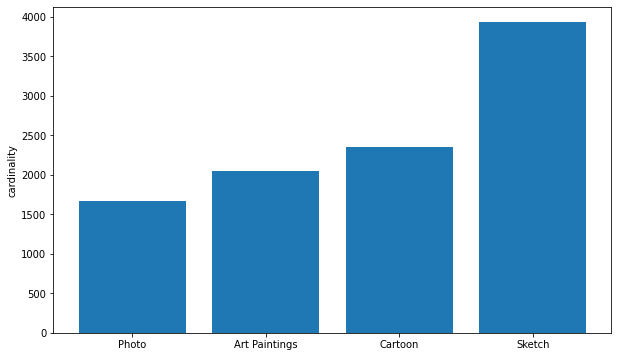

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,6))
x = np.arange(4)
y = [len(photo_dataset), len(art_dataset), len(cartoon_dataset), len(sketch_dataset)]
plt.bar(x,y)
plt.xticks(x, ('Photo', 'Art Paintings', 'Cartoon', 'Sketch'))
plt.ylabel('cardinality')

len(photo_dataset), len(art_dataset), len(cartoon_dataset), len(sketch_dataset)

**Set hyperparameters**

In [ ]:
DEVICE = 'cuda' 
BATCH_SIZE = 128
LR = 0.001
MOMENTUM = 0.9    
WEIGHT_DECAY = 5e-5 
NUM_EPOCHS = 30      
STEP_SIZE = 20      
GAMMA = 0.1    
LOG_FREQUENCY = 10

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

# Train on source, test on target without adaptation

**Prepare Network and Training**

In [ ]:
net = alexnet(pretrained=True)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train on source, test on target wihout adaptation**




In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

train_losses = []
losses_test = []
accuracies_test_noDANN = []
accuracies_train_noDANN = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images, None)
    loss = criterion(outputs, labels)

    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    loss.backward()  
    optimizer.step()
    current_step += 1

  scheduler.step() 
  
  train_losses.append(loss.item())
  accuracy_test, test_loss = evaluation(test_dataloader, net)
  accuracy_train, _ = evaluation(train_dataloader, net)
  accuracies_test_noDANN.append(accuracy_test)
  accuracies_train_noDANN.append(accuracy_train)
  losses_test.append(test_loss)
  
accuracy_test, test_loss = evaluation(test_dataloader, net)
print(f"accuracy: {accuracy_test} | loss: {test_loss} on test set ")

**Plotting features** 


In [ ]:
from sklearn.manifold import TSNE

def get_2D_representation(loader, net, class_label):
  all_images = []
  with torch.no_grad():
    net.train(False)
    for images, labels in loader:
        for img, label  in  zip(images, labels):
          if label == class_label:
            features = net.features(img.unsqueeze(0).cuda())
            features = net.avgpool(features)
            features = torch.flatten(features,1).squeeze(0)
            all_images.append(features)

    all_images = torch.stack(all_images)
  
    reduced_2D_images = TSNE().fit_transform(all_images.cpu().detach().numpy())
    return reduced_2D_images

reduced_2D_images_source = get_2D_representation(train_dataloader, net, 2)
reduced_2D_images_target = get_2D_representation(test_dataloader, net, 2)

fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(reduced_2D_images_source[:,0], reduced_2D_images_source[:,1], c = 'blue', label = 'source (train)')
ax.scatter(reduced_2D_images_target[:,0], reduced_2D_images_target[:,1], c = 'orange', label = 'target (test)')
ax.legend()

In [ ]:
results = f"LR={LR} | NUM_EPOCHS={NUM_EPOCHS} | GAMMA={GAMMA} | STEP_SIZE={STEP_SIZE} | BATCH_SIZE={BATCH_SIZE} | ACCURACY_TEST={accuracy}\n"
f = open("drive/My Drive/results_hm3.txt",'a')
f.write(results)
f.close()

# Train on source, test on target with adaptation

**Set hyperparameters**


In [ ]:
DEVICE = 'cuda' 
BATCH_SIZE = 128
LR = 0.001
MOMENTUM = 0.9    
WEIGHT_DECAY = 5e-5 
NUM_EPOCHS = 30      
STEP_SIZE = 20      
GAMMA = 0.1    
LOG_FREQUENCY = 10         
ALPHA = 0.01 

**Train on source, test on target with adaptation**

In [ ]:
# Prepare Pytorch train/test Datasets
photo_root = "homework_3/PACS/photo/"
art_root = "homework_3/PACS/art_painting/"
photo_dataset = torchvision.datasets.ImageFolder(photo_root, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_root, transform=train_transform)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

In [ ]:
net = alexnet(pretrained=True)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE) 
cudnn.benchmark
current_step = 0

losses_source_Gy = []
losses_source_Gd = []
losses_target_Gd = []
test_losses_DANN = []
train_losses_DANN = []

accuracies_train_DANN = []
accuracies_test_DANN = []
for epoch in range(NUM_EPOCHS):

  source_dataloader_iterator = iter(source_dataloader)
  
  for target_images, _ in target_dataloader:
    try: 
      images, labels = next(source_dataloader_iterator)
    except StopIteration:
        source_dataloader_iterator = iter(source_dataloader)
        images, labels = next(source_dataloader_iterator)

    target_images = target_images.to(DEVICE)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    net.train() 
    optimizer.zero_grad()

    # STEP 1
    outputs = net(images, None)
    loss_1 = criterion(outputs, labels)
    loss_1.backward() 

    # STEP 2
    outputs = net(images, ALPHA)
    step2_labels = torch.zeros(BATCH_SIZE, dtype=torch.long)
    step2_labels = step2_labels.to(DEVICE)
    loss_2 = criterion(outputs, step2_labels)
    loss_2.backward()  

    # STEP 3
    outputs = net(target_images, ALPHA)
    step3_labels = torch.ones(BATCH_SIZE, dtype=torch.long)
    step3_labels = step3_labels.to(DEVICE)
    loss_3 = criterion(outputs, step3_labels)
    loss_3.backward()

    optimizer.step() 
    current_step += 1

  #losses_source_Gy.append(loss_1.item()) 
  #losses_source_Gd.append(loss_2.item()) 
  #losses_target_Gd.append(loss_3.item())
  #test_acc, test_loss_DANN = evaluation(target_dataloader, net)
  #train_acc, train_loss_DANN = evaluation(source_dataloader, net)
  #train_losses_DANN.append(train_loss_DANN)
  #test_losses_DANN.append(test_loss_DANN)
  #accuracies_test_DANN.append(test_acc)
  #accuracies_train_DANN.append(train_acc)
  scheduler.step()

**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(target_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images, None)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(target_dataloader.dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Accuracy: 0.5009765625


In [ ]:
# class label 0 stands for "dogs"
reduced_2D_images_source = get_2D_representation(source_dataloader, net, 2)
reduced_2D_images_target = get_2D_representation(target_dataloader, net, 2)
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(reduced_2D_images_source[:,0], reduced_2D_images_source[:,1], c = 'blue', label = 'source')
ax.scatter(reduced_2D_images_target[:,0], reduced_2D_images_target[:,1], c = 'orange', label = 'target')
ax.legend()

In [ ]:
results = f"DANN with ALPHA={ALPHA} | LR={LR} | NUM_EPOCHS={NUM_EPOCHS} | GAMMA={GAMMA} | STEP_SIZE={STEP_SIZE} | BATCH_SIZE={BATCH_SIZE} | ACCURACY_TEST={accuracy}\n"
f = open("drive/My Drive/results_DANN_hm3.txt",'a')
f.write(results)
f.close()

# Comparison

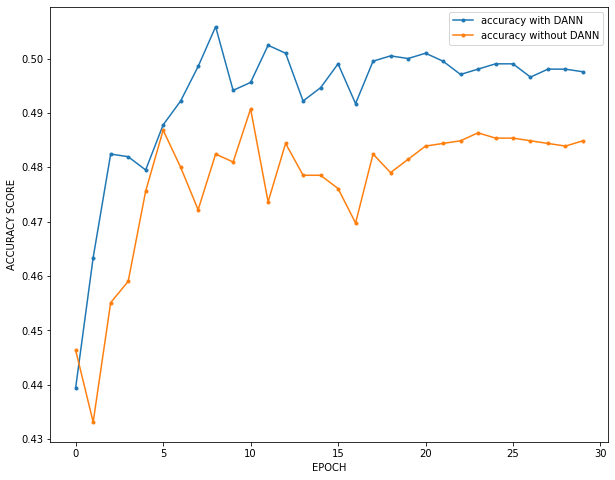

(0.49755859375, 0.48486328125)

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,8))

ax.plot(accuracies_test_DANN, label = "accuracy with DANN", marker='.')
ax.plot(accuracies_test_noDANN, label = "accuracy without DANN", marker='.')

plt.xlabel('EPOCH')
plt.ylabel('ACCURACY SCORE')
plt.title('')
plt.legend()
plt.show()

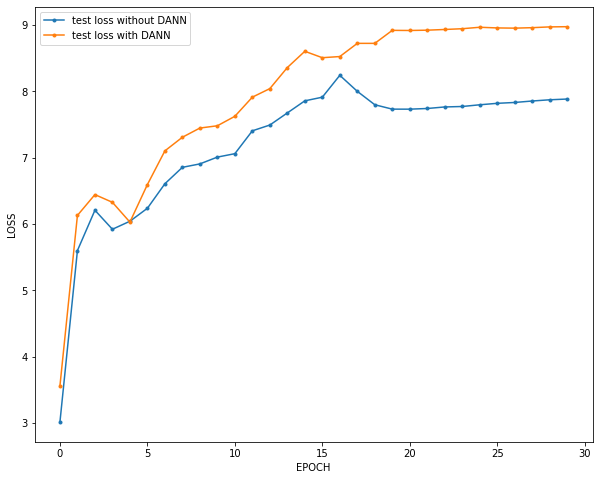

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,8))

ax.plot(losses_test, label = "test loss without DANN", marker='.')
ax.plot(test_losses_DANN, label = "test loss with DANN", marker='.')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('')
plt.legend()
plt.show()

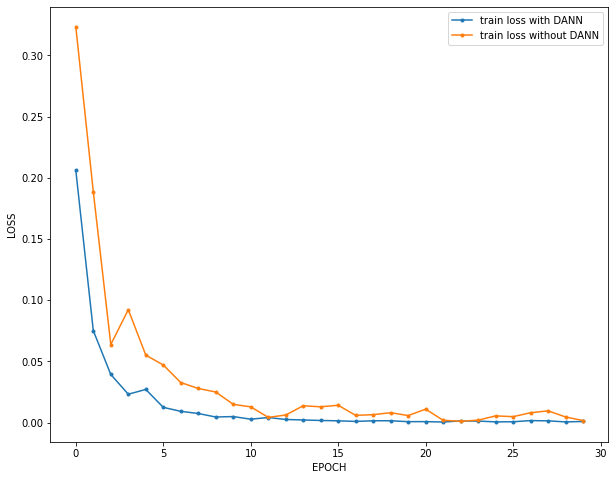

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,8))

ax.plot(train_losses_DANN, label = "train loss with DANN", marker='.')
ax.plot(train_losses, label = "train loss without DANN", marker='.')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('')
plt.legend()
plt.show()

# Cross Domain Validation without DANN

**Cross Domain Validation without DANN**

In [ ]:
photo_dataset = torchvision.datasets.ImageFolder(photo_root, transform=train_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_root, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_root, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_root, transform=train_transform)

photo_valoader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_valoader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
sketch_valoader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
art_valoader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

In [ ]:
# First, only the learning rate is tuned
# LR, NUM_EPOCHS, STEP_SIZE, GAMMA, WEIGHT_DECAY
params_configurations = [[0.0001, 30, 20, 0.1, 5e-5],
                         [0.0005, 30, 20, 0.1, 5e-5],
                         [0.005, 30, 20, 0.1, 5e-5],
                         [0.001, 30, 20, 0.1, 5e-5],
                         [0.01, 30, 20, 0.1, 5e-5]]
config_scores = {}
for config_idx, config in enumerate(params_configurations):
  LR = config[0]
  NUM_EPOCHS = config[1]
  STEP_SIZE = config[2]
  GAMMA = config[3]
  WEIGHT_DECAY = config[4]

  net = alexnet(pretrained=True)
  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  trained_net = training(None, photo_valoader, net, NUM_EPOCHS, scheduler, optimizer)
  accuracy_cartoon, loss_cartoon = evaluation(cartoon_valoader, trained_net)
  accuracy_sketch, loss_sketch = evaluation(sketch_valoader, trained_net)

  avg_accuracy = (accuracy_cartoon + accuracy_sketch)/2
  avg_loss = (loss_cartoon + loss_sketch)/2
  
  config_scores[config_idx] = (avg_accuracy, avg_loss) 

  print(f"Evaluated model with config={config}")
  print(f"accuracy_cartoon={accuracy_cartoon} loss_cartoon={loss_cartoon}")
  print(f"accuracy_sketch={accuracy_sketch} loss_sketch={loss_sketch}")
  print(f"avg_accuracy={avg_accuracy} avg_loss={avg_loss}")


100%|██████████| 18/18 [00:08<00:00,  2.10it/s]

100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Evaluated model with config=[0.0001, 30, 20, 0.1, 5e-05]
accuracy_cartoon=0.2521331058020478 loss_cartoon=4.653696060180664
accuracy_sketch=0.3013489437515907 loss_sketch=3.217373847961426
avg_accuracy=0.2767410247768193 avg_loss=3.935534954071045



100%|██████████| 18/18 [00:08<00:00,  2.12it/s]

100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


Evaluated model with config=[0.0005, 30, 20, 0.1, 5e-05]
accuracy_cartoon=0.2431740614334471 loss_cartoon=7.162662506103516
accuracy_sketch=0.2794604224993637 loss_sketch=6.234256267547607
avg_accuracy=0.2613172419664054 avg_loss=6.6984593868255615



100%|██████████| 18/18 [00:08<00:00,  2.14it/s]

100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Evaluated model with config=[0.005, 30, 20, 0.1, 5e-05]
accuracy_cartoon=0.25810580204778155 loss_cartoon=11.275652885437012
accuracy_sketch=0.3112751336217867 loss_sketch=8.790472984313965
avg_accuracy=0.28469046783478413 avg_loss=10.033062934875488



100%|██████████| 18/18 [00:08<00:00,  2.12it/s]

100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Evaluated model with config=[0.001, 30, 20, 0.1, 5e-05]
accuracy_cartoon=0.2431740614334471 loss_cartoon=9.207777976989746
accuracy_sketch=0.2812420463222194 loss_sketch=5.214203357696533
avg_accuracy=0.26220805387783325 avg_loss=7.21099066734314



100%|██████████| 18/18 [00:08<00:00,  2.13it/s]

100%|██████████| 30/30 [00:12<00:00,  2.31it/s]

Evaluated model with config=[0.01, 30, 20, 0.1, 5e-05]
accuracy_cartoon=0.25554607508532423 loss_cartoon=14.220627784729004
accuracy_sketch=0.29931280223975565 loss_sketch=9.347529411315918
avg_accuracy=0.27742943866253994 avg_loss=11.784078598022461


In [ ]:
config_scores, params_configurations # configuration with best accuracy

({0: (0.2767410247768193, 3.935534954071045),
  1: (0.2613172419664054, 6.6984593868255615),
  2: (0.28469046783478413, 10.033062934875488),
  3: (0.26220805387783325, 7.21099066734314),
  4: (0.27742943866253994, 11.784078598022461)},
 [[0.0001, 30, 20, 0.1, 5e-05],
  [0.0005, 30, 20, 0.1, 5e-05],
  [0.005, 30, 20, 0.1, 5e-05],
  [0.001, 30, 20, 0.1, 5e-05],
  [0.01, 30, 20, 0.1, 5e-05]])

In [ ]:
# Then, other parameters are tuned with the best learning rate fixed

params_configurations = [[0.005, 50, 20, 0.1, 0.005],
                         [0.005, 50, 25, 0.1, 0.005],
                         [0.005, 50, 30, 0.1, 0.005]]
config_scores = {}
for config_idx, config in enumerate(params_configurations):
  LR = config[0]
  NUM_EPOCHS = config[1]
  STEP_SIZE = config[2]
  GAMMA = config[3]
  WEIGHT_DECAY = config[4]

  net = alexnet(pretrained=True)
  print(net.classifier[6])
  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  trained_net = training(None, photo_valoader, net, NUM_EPOCHS, scheduler, optimizer)
  accuracy_cartoon, loss_cartoon = evaluation(cartoon_valoader, trained_net)
  accuracy_sketch, loss_sketch = evaluation(sketch_valoader, trained_net)

  avg_accuracy = (accuracy_cartoon + accuracy_sketch)/2
  avg_loss = (loss_cartoon + loss_sketch)/2
  
  config_scores[config_idx] = (avg_accuracy, avg_loss) 

  print(f"Evaluated model with config={config}")
  print(f"accuracy_cartoon={accuracy_cartoon} loss_cartoon={loss_cartoon}")
  print(f"accuracy_sketch={accuracy_sketch} loss_sketch={loss_sketch}")
  print(f"avg_accuracy={avg_accuracy} avg_loss={avg_loss}")

Linear(in_features=4096, out_features=7, bias=True)


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Evaluated model with config=[0.005, 50, 20, 0.1, 0.005]
accuracy_cartoon=0.27261092150170646 loss_cartoon=10.203784942626953
accuracy_sketch=0.319419699669127 loss_sketch=9.139816284179688
avg_accuracy=0.29601531058541675 avg_loss=9.67180061340332
Linear(in_features=4096, out_features=7, bias=True)


100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Evaluated model with config=[0.005, 50, 25, 0.1, 0.005]
accuracy_cartoon=0.27986348122866894 loss_cartoon=9.89080810546875
accuracy_sketch=0.32832781878340545 loss_sketch=6.3654303550720215
avg_accuracy=0.3040956500060372 avg_loss=8.128119230270386
Linear(in_features=4096, out_features=7, bias=True)


100%|██████████| 30/30 [00:13<00:00,  2.27it/s]

Evaluated model with config=[0.005, 50, 30, 0.1, 0.005]
accuracy_cartoon=0.2645051194539249 loss_cartoon=9.558392524719238
accuracy_sketch=0.3130567574446424 loss_sketch=6.110206127166748
avg_accuracy=0.28878093844928365 avg_loss=7.834299325942993


# Cross Domain Validation with DANN

In [ ]:
photo_dataset = torchvision.datasets.ImageFolder(photo_root, transform=train_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_root, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_root, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_root, transform=train_transform)

photo_loader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_loader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
sketch_loader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
art_loader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

**Cross Domain Validation with DANN**

In [ ]:
def training_with_adaptation(source_dataloader, target_dataloader, net, scheduler, optimizer):
  net = alexnet(pretrained=True)

  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net = net.to(DEVICE) 
  cudnn.benchmark
  current_step = 0

  losses_source_Gy = []
  losses_source_Gd = []
  losses_target_Gd = []

  for epoch in range(NUM_EPOCHS):

    target_dataloader_iterator = iter(target_dataloader)

    for images, labels in source_dataloader:
      
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      """ 1. train on source labels by forwarding source
      data to Gy, get the loss, and update
      gradients with loss.backward() """

      net.train() 
      optimizer.zero_grad()
      outputs = net(images, None)
      loss_1 = criterion(outputs, labels)

      loss_1.backward() 

      """ 2. train the discriminator by forwarding
      source data to Gd, get the loss (the label is 0
      for all data), and update gradients with
      loss.backward() """

      outputs = net(images, ALPHA)
      step2_labels = torch.zeros(BATCH_SIZE, dtype=torch.long)
      step2_labels = step2_labels.to(DEVICE)
      loss_2 = criterion(outputs, step2_labels)

      loss_2.backward()  

      """ 3. (SEPARATE DATALOADER) train the discriminator by forwarding target
      data to Gd, get the loss (the label is 1), and
      update gradients with loss.backward() """

      step3_images = next(target_dataloader_iterator)
      step3_images = step3_images[0].to(DEVICE)
      outputs = net(step3_images, ALPHA)
      step3_labels = torch.ones(BATCH_SIZE, dtype=torch.long)
      step3_labels = step3_labels.to(DEVICE)
      loss_3 = criterion(outputs, step3_labels)

      loss_3.backward()

      optimizer.step() 
      current_step += 1

    losses_source_Gy.append(loss_1.item()) 
    losses_source_Gd.append(loss_2.item()) 
    losses_target_Gd.append(loss_3.item()) 
    scheduler.step()
  return copy.deepcopy(net)

In [ ]:
params_configurations = [[0.005,	30,	20,	0.1, 0.005,	0.05],
                         [0.005,	50,	20,	0.1, 0.005,	0.05],
                         [0.0005,	30,	20,	0.1, 0.005,	0.01],
                         [0.0001,	30,	20,	0.1, 0.005,	0.05]]
config_scores_2 = {}
for config_idx, config in enumerate(params_configurations):
  LR = config[0]
  NUM_EPOCHS = config[1]
  STEP_SIZE = config[2]
  GAMMA = config[3]
  WEIGHT_DECAY = config[4]
  ALPHA = config[5]

  net = alexnet(pretrained=True)
  
  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  trained_net_1 = training_with_adaptation(photo_loader, cartoon_loader, net, scheduler, optimizer)
  trained_net_2 = training_with_adaptation(photo_loader, sketch_loader, net, scheduler, optimizer)
  accuracy_cartoon, loss_cartoon = evaluation(cartoon_loader, trained_net_1)
  accuracy_sketch, loss_sketch = evaluation(sketch_valoader, trained_net_2)

  avg_accuracy = (accuracy_cartoon + accuracy_sketch)/2
  avg_loss = (loss_cartoon + loss_sketch)/2
  
  config_scores_2[config_idx] = (avg_accuracy, avg_loss) 

  print(f"Evaluated model with config: {config}")
  print(f"accuracy_cartoon={accuracy_cartoon} loss_cartoon={loss_cartoon}")
  print(f"accuracy_sketch={accuracy_sketch} loss_sketch={loss_sketch}")
  print(f"avg_accuracy={avg_accuracy} avg_loss={avg_loss}")
  

100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


Evaluated model with config: [0.005, 30, 20, 0.1, 0.005, 0.05]
accuracy_cartoon=0.4552047781569966 loss_cartoon=11.950801849365234
accuracy_sketch=0.23924662764062102 loss_sketch=7.191900253295898
avg_accuracy=0.34722570289880883 avg_loss=9.571351051330566


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Evaluated model with config: [0.005, 50, 20, 0.1, 0.005, 0.05]
accuracy_cartoon=0.47909556313993173 loss_cartoon=13.4350004196167
accuracy_sketch=0.29931280223975565 loss_sketch=7.646337032318115
avg_accuracy=0.3892041826898437 avg_loss=10.540668725967407


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


Evaluated model with config: [0.0005, 30, 20, 0.1, 0.005, 0.01]
accuracy_cartoon=0.2619453924914676 loss_cartoon=6.6703386306762695
accuracy_sketch=0.2616441842708068 loss_sketch=5.248318195343018
avg_accuracy=0.26179478838113723 avg_loss=5.9593284130096436


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]

Evaluated model with config: [0.0001, 30, 20, 0.1, 0.005, 0.05]
accuracy_cartoon=0.2188566552901024 loss_cartoon=4.277695655822754
accuracy_sketch=0.17179944006108425 loss_sketch=3.9073333740234375
avg_accuracy=0.1953280476755933 avg_loss=4.092514514923096


In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,8))

ax.plot(losses_source_Gd, label = "loss of source to Gd", marker='.')
ax.plot(losses_source_Gy, label = "loss of source to Gy", marker='.')
ax.plot(losses_target_Gd, label = "loss of target to Gd", marker='.')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('')
plt.legend()
plt.show()